In [110]:
import os
import utils
import numpy as np

In [111]:
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, LabelBinarizer, StandardScaler

In [112]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm_notebook
import sklearn.metrics as metrics

In [113]:
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

In [ ]:
from sklearn.metrics import balanced_accuracy_score, make_scorer

In [ ]:
tracks = utils.load('tracks.csv')
features = utils.load('features.csv')
echonest = utils.load('echonest.csv')

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

# Base Model

In [115]:
tracks_filtered = tracks[tracks['track']['genre_top'].isin(['Rock', 'Experimental', 'Electronic', 'Hip-Hop', 'Folk', 'Pop', 
                                        'Instrumental', 'International', 'Classical'])].copy()

# Medium = 23,561
# All = 47,547

In [116]:
# Splitting data into train, valid and test

train = tracks_filtered.index[tracks_filtered['set', 'split'] == 'training']
val = tracks_filtered.index[tracks_filtered['set', 'split'] == 'validation']
test = tracks_filtered.index[tracks_filtered['set', 'split'] == 'test']

In [117]:
y_train = tracks_filtered['track', 'genre_top'][train]
y_val = tracks_filtered['track', 'genre_top'][val]
y_test = tracks_filtered['track', 'genre_top'][test]

x_train = features.loc[train]
x_val = features.loc[val]
x_test = features.loc[test]

In [118]:
knn = KNeighborsClassifier(n_neighbors = 200)

knn.fit(x_train, y_train)

y_pred_knn = knn.predict(x_test)

In [119]:
from itertools import product

def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=90)
    plt.yticks(tick_marks, names)
    
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
        horizontalalignment="center",
        color="white" if cm[i, j] > 500 else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [120]:
labelNames = ['Rock', 'Experimental', 'Electronic', 'Hip-Hop', 'Folk', 'Pop', 'Instrumental', 'International', 'Classical']
labelNames.sort()

In [121]:
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 200,
 'p': 2,
 'weights': 'uniform'}

In [122]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred_knn)

[[   1    7   60    3    0    2    0    0   14]
 [   5  518   93   13   20    0    0    0  190]
 [  14  246  356   31   13   17    0    0  408]
 [   6    7  131   28    0    2    0    0  125]
 [   0  107   14    3   71    1    0    0  127]
 [   5   54  153   25    1    9    0    0   62]
 [   0   34    8    2    2    0    0    0   82]
 [   0   82   26    4    4    0    0    0   88]
 [   2  125  116   12    6    1    0    0 1202]]


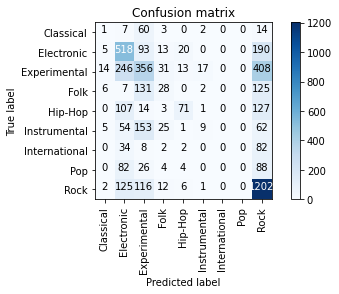

In [123]:
print(confusion_matrix)
plt.figure()
plot_confusion_matrix(confusion_matrix, labelNames)
plt.show()

In [34]:
print(metrics.recall_score(y_test,y_pred_knn, average = 'weighted'))
print(metrics.precision_score(y_test,y_pred_knn, average = 'weighted'))
print(metrics.f1_score(y_test,y_pred_knn, average = 'weighted'))
print(metrics.accuracy_score(y_test,y_pred_knn))

0.46116504854368934
0.3994150487547829
0.4023266881985469
0.46116504854368934


C:\Users\hypw\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [74]:
ovr_knn_vanilla = OneVsRestClassifier(KNeighborsClassifier(n_neighbors = 200))

y_train = tracks_filtered['track', 'genre_top'][train]
y_val = tracks_filtered['track', 'genre_top'][val]
y_test = tracks_filtered['track', 'genre_top'][test]

x_train = features.loc[train]
x_val = features.loc[val]
x_test = features.loc[test]

ovr_knn_vanilla.fit(x_train, y_train)

# y_pred_ovr_knn = ovr_knn.predict(x_test)
y_pred_ovr_knn_probability_vanilla = ovr_knn_vanilla.predict_proba(x_test)

auc_score = roc_auc_score(y_test, y_pred_ovr_knn_probability_vanilla, multi_class = 'ovr')
print(auc_score)

0.746997203988951


# Oversampling - Base Model

In [19]:
# !pip install imblearn

In [124]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [125]:
oversampler = RandomOverSampler(random_state = 0)
oversample_x_train, oversample_y_train = oversampler.fit_resample(x_train, y_train)

In [126]:
knn.fit(oversample_x_train, oversample_y_train)

oversample_y_pred_knn = knn.predict(x_test)

In [127]:
np.unique(oversample_y_pred_knn)

array(['Classical', 'Electronic', 'Experimental', 'Folk', 'Hip-Hop',
       'Instrumental', 'International', 'Pop', 'Rock'], dtype=object)

In [128]:
oversample_confusion_matrix = metrics.confusion_matrix(y_test, oversample_y_pred_knn)

[[ 32   1   4  18   1  25   5   1   0]
 [ 24 307  11  88 199  53  73  43  41]
 [ 96 133  63 187 155 138 146  71  96]
 [ 51   3   9  85  20  41  45  19  26]
 [  1  29   0  21 198   9  36  16  13]
 [ 66  27   9  82  18  62  16  18  11]
 [  3  11   1   7  22   1  34  13  36]
 [  1  39   0  52  49   9  23  16  15]
 [ 34  96  20 104 153  34 263 112 648]]


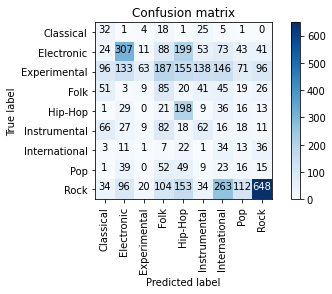

In [129]:
print(oversample_confusion_matrix)
plt.figure()
plot_confusion_matrix(oversample_confusion_matrix, labelNames)
plt.show()

In [25]:
print(metrics.recall_score(y_test,oversample_y_pred_knn, average = 'micro'))
print(metrics.precision_score(y_test,oversample_y_pred_knn, average = 'micro'))
print(metrics.f1_score(y_test,oversample_y_pred_knn, average = 'micro'))
print(metrics.accuracy_score(y_test,oversample_y_pred_knn))

0.3049810046433094
0.3049810046433094
0.3049810046433094
0.3049810046433094


In [77]:
ovr_knn_vanilla_over = OneVsRestClassifier(KNeighborsClassifier(n_neighbors = 200))

ovr_knn_vanilla_over.fit(oversample_x_train, oversample_y_train)

# y_pred_ovr_knn = ovr_knn.predict(x_test)
y_pred_ovr_knn_probability_vanilla_over = ovr_knn_vanilla_over.predict_proba(x_test)

auc_score = roc_auc_score(y_test, y_pred_ovr_knn_probability_vanilla_over, multi_class = 'ovr')
print(auc_score)

0.73574591297773


# Undersampling

In [130]:
undersampler = RandomUnderSampler(random_state = 0)
undersample_x_train, undersample_y_train = undersampler.fit_resample(x_train, y_train)

knn.fit(undersample_x_train, undersample_y_train)
undersample_y_pred_knn = knn.predict(x_test)

In [132]:
undersample_confusion_matrix = metrics.confusion_matrix(y_test, undersample_y_pred_knn)

[[ 26   5   0  29   1  23   1   2   0]
 [ 27 288   0 135 253  40  24  31  41]
 [139 149   6 222 193 114  74  65 123]
 [ 50   4   0 113  28  33  27  17  27]
 [  1  18   0  27 210  11  17  16  23]
 [ 66  18   0  99  20  49  10  31  16]
 [  5  12   0  11  32   1  13  11  43]
 [  4  33   0  53  62   8  10  10  24]
 [ 49  73   2 143 240  36 124  68 729]]


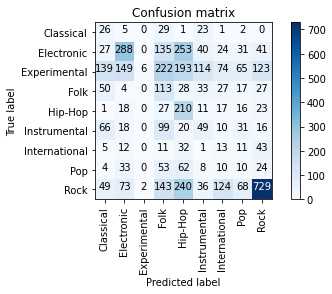

In [133]:
print(undersample_confusion_matrix)
plt.figure()
plot_confusion_matrix(undersample_confusion_matrix, labelNames)
plt.show()

In [31]:
print(metrics.recall_score(y_test,undersample_y_pred_knn, average = 'micro'))
print(metrics.precision_score(y_test,undersample_y_pred_knn, average = 'micro'))
print(metrics.f1_score(y_test,undersample_y_pred_knn, average = 'micro'))
print(metrics.accuracy_score(y_test,undersample_y_pred_knn))

0.3047699451245251
0.3047699451245251
0.3047699451245251
0.3047699451245251


In [78]:
ovr_knn_vanilla_under = OneVsRestClassifier(KNeighborsClassifier(n_neighbors = 200))

undersampler = RandomUnderSampler(random_state = 0)
undersample_x_train, undersample_y_train = undersampler.fit_resample(x_train, y_train)

ovr_knn_vanilla_under.fit(undersample_x_train, undersample_y_train)

y_pred_ovr_knn_probability_vanilla_under = ovr_knn_vanilla_under.predict_proba(x_test)

auc_score = roc_auc_score(y_test, y_pred_ovr_knn_probability_vanilla_under, multi_class = 'ovr')
print(auc_score)

0.718391989423284


# Under/Over Sampling Conclusion

Both under and oversampling resulted in an increase in precision, but decrease in accuracy, f1 and recall score.

# PCA

In [134]:
from sklearn.decomposition import PCA

In [135]:
scaler = StandardScaler()
scaled_train_features = scaler.fit_transform(x_train)
scaled_test_features = scaler.fit_transform(x_test)

In [136]:
pca = PCA(n_components = 0.95)
pca.fit(scaled_train_features)
reduced_train_features = pca.transform(scaled_train_features)
reduced_test_features = pca.transform(scaled_test_features)

In [138]:
knn.fit(reduced_train_features, y_train)
y_pred_knn_PCA = knn.predict(reduced_test_features)

[[  60    0   17    5    0    0    0    0    5]
 [   8  410  122    9   64    0    0    0  226]
 [  15   65  468   34   24    2    0    0  477]
 [   6    0   44   53    0    0    0    0  196]
 [   0   50   24    0  196    1    0    0   52]
 [  31    8   58   76    1    3    1    0  131]
 [   2   12    6   23   10    0    5    0   70]
 [   1   36   20   14   15    0    0    0  118]
 [   2   15   74   20    9    0    0    0 1344]]


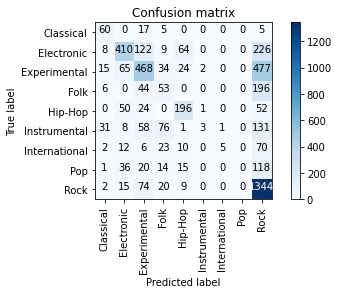

In [139]:
pca_confusion_matrix = metrics.confusion_matrix(y_test, y_pred_knn_PCA)
print(pca_confusion_matrix)
plt.figure()
plot_confusion_matrix(pca_confusion_matrix, labelNames)
plt.show()

In [20]:
print(metrics.recall_score(y_test,y_pred_knn_PCA, average = 'weighted'))
print(metrics.precision_score(y_test,y_pred_knn_PCA, average = 'weighted'))
print(metrics.f1_score(y_test,y_pred_knn_PCA, average = 'weighted'))
print(metrics.accuracy_score(y_test,y_pred_knn_PCA))

0.5358801181933305
0.5291549290777426
0.4841904645558979
0.5358801181933305


C:\Users\hypw\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [83]:
ovr_knn_pca = OneVsRestClassifier(KNeighborsClassifier(n_neighbors = 200))

ovr_knn_pca.fit(reduced_train_features, y_train)

y_pred_ovr_knn_probability_pca_over = ovr_knn_pca.predict_proba(reduced_test_features)

auc_score = roc_auc_score(y_test, y_pred_ovr_knn_probability_pca_over, multi_class = 'ovr')
print(auc_score)

0.8529949237049163


# PCA with Oversampling

In [140]:
oversampler = RandomOverSampler(random_state = 0)
oversample_pca_x_train, oversample_pca_y_train = oversampler.fit_resample(reduced_train_features, y_train)

In [141]:
knn.fit(oversample_pca_x_train, oversample_pca_y_train)
oversample_pca_y_pred_knn = knn.predict(reduced_test_features)

[[  77    0    2    5    0    0    3    0    0]
 [  17  188   46   48  268   19  165   35   53]
 [  68   45  292   90  115   60  191   44  180]
 [  23    0    4  116    5    5   93    3   50]
 [   0   13    5    2  248    2   43    0   10]
 [  58    2   21   88   10   36   51   12   31]
 [   3    2    0   23   17    1   75    1    6]
 [   2    6    2   33   35    7   82   21   16]
 [  14   15   37   72   66   16  191   38 1015]]


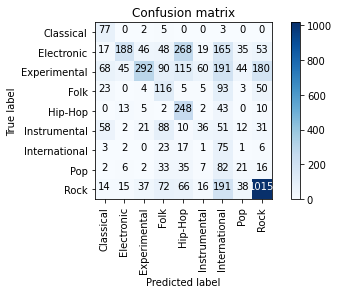

In [142]:
pca_oversample_confusion_matrix = metrics.confusion_matrix(y_test, oversample_pca_y_pred_knn)
print(pca_oversample_confusion_matrix)
plt.figure()
plot_confusion_matrix(pca_oversample_confusion_matrix, labelNames)
plt.show()

In [55]:
print(metrics.recall_score(y_test,oversample_pca_y_pred_knn, average = 'micro'))
print(metrics.precision_score(y_test,oversample_pca_y_pred_knn, average = 'micro'))
print(metrics.f1_score(y_test,oversample_pca_y_pred_knn, average = 'micro'))
print(metrics.accuracy_score(y_test,oversample_pca_y_pred_knn))

0.43647108484592656
0.43647108484592656
0.43647108484592656
0.43647108484592656


In [85]:
ovr_knn_pca_over = OneVsRestClassifier(KNeighborsClassifier(n_neighbors = 200))

oversampler = RandomOverSampler(random_state = 0)
oversample_pca_x_train, oversample_pca_y_train = oversampler.fit_resample(reduced_train_features, y_train)

ovr_knn_pca_over.fit(oversample_pca_x_train, oversample_pca_y_train)

y_pred_ovr_knn_probability_pca_over = ovr_knn_pca_over.predict_proba(reduced_test_features)

auc_score = roc_auc_score(y_test, y_pred_ovr_knn_probability_pca_over, multi_class = 'ovr')
print(auc_score)

0.8198823096542643


# PCA with Undersampling

In [143]:
undersampler = RandomUnderSampler(random_state = 0)
undersample_pca_x_train, undersample_pca_y_train = undersampler.fit_resample(reduced_train_features, y_train)

In [144]:
knn.fit(undersample_pca_x_train, undersample_pca_y_train)
undersample_pca_y_pred_knn = knn.predict(reduced_test_features)

[[  78    0    2    3    0    0    4    0    0]
 [  20   82   10   44  411    9  152   13   98]
 [  99   45   99   80  196   26  229    6  305]
 [  29    0    1  104    4    2   91    1   67]
 [   1    3    1    3  273    1   24    0   17]
 [  77    3    9   97   17   10   46    4   46]
 [   9    1    0   13   26    0   70    1    8]
 [   1    2    0   27   46    2   88    7   31]
 [  17    5    7   61   68    2  180    6 1118]]


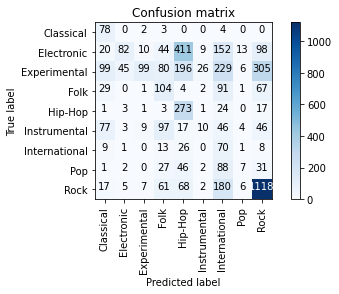

In [145]:
pca_undersample_confusion_matrix = metrics.confusion_matrix(y_test, undersample_pca_y_pred_knn)
print(pca_undersample_confusion_matrix)
plt.figure()
plot_confusion_matrix(pca_undersample_confusion_matrix, labelNames)
plt.show()

In [60]:
print(metrics.recall_score(y_test,undersample_pca_y_pred_knn, average = 'micro'))
print(metrics.precision_score(y_test,undersample_pca_y_pred_knn, average = 'micro'))
print(metrics.f1_score(y_test,undersample_pca_y_pred_knn, average = 'micro'))
print(metrics.accuracy_score(y_test,undersample_pca_y_pred_knn))

0.3885605740818911
0.3885605740818911
0.3885605740818911
0.3885605740818911


In [86]:
ovr_knn_pca_under = OneVsRestClassifier(KNeighborsClassifier(n_neighbors = 200))

undersampler = RandomUnderSampler(random_state = 0)
undersample_pca_x_train, undersample_pca_y_train = undersampler.fit_resample(reduced_train_features, y_train)

ovr_knn_pca_under.fit(undersample_pca_x_train, undersample_pca_y_train)

y_pred_ovr_knn_probability_pca_under = ovr_knn_pca_under.predict_proba(reduced_test_features)

auc_score = roc_auc_score(y_test, y_pred_ovr_knn_probability_pca_under, multi_class = 'ovr')
print(auc_score)

0.8336536170888144


# PCA + Hyperparameter tuning

Best leaf_size: 28

Best p: 2

n_neighbour = 191

In [80]:
leaf_size = list(range(28,32))
n_neighbors = list(range(190,211))
p=[2]
# p=[1,2]

hyperparameters = dict(leaf_size=leaf_size, p=p, n_neighbors=n_neighbors)
accu_score = make_scorer(balanced_accuracy_score)

In [71]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score, make_scorer, accuracy_score

In [ ]:
knn_2 = KNeighborsClassifier()
clf = GridSearchCV(knn_2, hyperparameters, cv=3, verbose = 10, scoring = accu_score)

y = y_train
x = reduced_train_features

best_model = clf.fit(x,y)

In [82]:
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

Best leaf_size: 28
Best p: 2
Best n_neighbors: 191


In [146]:
knn_pca_ht = KNeighborsClassifier(n_neighbors = 191, p = 2, leaf_size = 28)
knn_pca_ht.fit(reduced_train_features, y_train)

KNeighborsClassifier(leaf_size=28, n_neighbors=191)

In [147]:
y_pred_final = knn_pca_ht.predict(reduced_test_features)

[[  59    0   18    4    0    0    0    0    6]
 [   8  408  127    9   61    0    0    0  226]
 [  15   66  469   36   22    2    0    0  475]
 [   6    0   43   57    0    0    1    0  192]
 [   0   50   24    0  196    1    0    0   52]
 [  31    8   62   77    1    3    2    0  125]
 [   2   11    5   23   11    0    5    0   71]
 [   1   36   21   15   15    0    0    0  116]
 [   2   15   71   20   10    0    0    0 1346]]


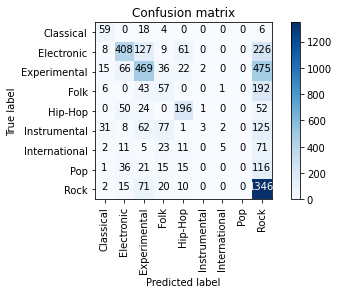

In [148]:
final_confusion_matrix = metrics.confusion_matrix(y_test, y_pred_final)
print(final_confusion_matrix)
plt.figure()
plot_confusion_matrix(final_confusion_matrix, labelNames)
plt.show()

In [86]:
print(metrics.recall_score(y_test,y_pred_final, average = 'weighted'))
print(metrics.precision_score(y_test,y_pred_final, average = 'weighted'))
print(metrics.f1_score(y_test,y_pred_final, average = 'weighted'))
print(metrics.accuracy_score(y_test,y_pred_final))

0.5367243562684677
0.5243386141597716
0.48528504904395126
0.5367243562684677


C:\Users\hypw\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [87]:
ovr_knn_pca_ht = OneVsRestClassifier(KNeighborsClassifier(n_neighbors = 191, p = 2, leaf_size = 28))

ovr_knn_pca_ht.fit(reduced_train_features, y_train)

y_pred_ovr_knn_probability_pca_ht = ovr_knn_pca_ht.predict_proba(reduced_test_features)

auc_score = roc_auc_score(y_test, y_pred_ovr_knn_probability_pca_ht, multi_class = 'ovr')
print(auc_score)

0.8524890392370323


In [79]:
y_pred_ovr_knn_probability_pca_ht[5]

array([0.   , 0.115, 0.15 , 0.08 , 0.15 , 0.025, 0.135, 0.07 , 0.275])

In [24]:
genre_prob = knn_pca_ht.predict_proba(reduced_test_features)
print(genre_prob)

[[0.01  0.04  0.195 ... 0.06  0.105 0.52 ]
 [0.    0.075 0.27  ... 0.07  0.075 0.43 ]
 [0.15  0.04  0.295 ... 0.03  0.055 0.375]
 ...
 [0.    0.055 0.13  ... 0.015 0.07  0.7  ]
 [0.    0.095 0.21  ... 0.055 0.04  0.505]
 [0.01  0.445 0.19  ... 0.04  0.035 0.08 ]]


# Under/Over Sampling + Final kNN

In [149]:
oversampler = RandomOverSampler(random_state = 0)
oversample_final_x_train, oversample_final_y_train = oversampler.fit_resample(reduced_train_features, y_train)

undersampler = RandomUnderSampler(random_state = 0)
undersample_final_x_train, undersample_final_y_train = undersampler.fit_resample(reduced_train_features, y_train)

In [150]:
knn_pca_ht.fit(oversample_final_x_train, oversample_final_y_train)

KNeighborsClassifier(leaf_size=28, n_neighbors=191)

In [151]:
y_pred_final_oversample = knn_pca_ht.predict(reduced_test_features)

In [152]:
print(metrics.recall_score(y_test,y_pred_final_oversample, average = 'micro'))
print(metrics.precision_score(y_test,y_pred_final_oversample, average = 'micro'))
print(metrics.f1_score(y_test,y_pred_final_oversample, average = 'micro'))
print(metrics.accuracy_score(y_test,y_pred_final_oversample))

0.43921485859012244
0.43921485859012244
0.43921485859012244
0.43921485859012244


[[  77    0    2    5    0    0    3    0    0]
 [  17  196   48   45  261   19  167   36   50]
 [  68   43  297   92  113   54  196   41  181]
 [  21    0    4  115    5    6   95    3   50]
 [   1   12    5    1  248    1   46    0    9]
 [  59    3   19   89    9   35   50   14   31]
 [   3    2    0   23   18    1   74    1    6]
 [   2    6    2   34   36    7   80   21   16]
 [  13   15   37   71   70   16  187   37 1018]]


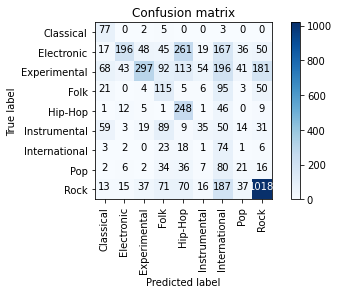

In [153]:
final_over_confusion_matrix = metrics.confusion_matrix(y_test, y_pred_final_oversample)
print(final_over_confusion_matrix)
plt.figure()
plot_confusion_matrix(final_over_confusion_matrix, labelNames)
plt.show()

In [154]:
ovr_knn_pca_ht_over = OneVsRestClassifier(knn_pca_ht)

oversampler = RandomOverSampler(random_state = 0)
oversample_final_x_train, oversample_final_y_train = oversampler.fit_resample(reduced_train_features, y_train)

ovr_knn_pca_ht_over.fit(oversample_final_x_train, oversample_final_y_train)

y_pred_ovr_knn_probability_pca_ht_over = ovr_knn_pca_ht_over.predict_proba(reduced_test_features)

auc_score = roc_auc_score(y_test, y_pred_ovr_knn_probability_pca_ht_over, multi_class = 'ovr')
print(auc_score)

0.8196450911931419


In [155]:
knn_pca_ht.fit(undersample_final_x_train, undersample_final_y_train)
y_pred_final_undersample = knn_pca_ht.predict(reduced_test_features)

In [156]:
print(metrics.recall_score(y_test,y_pred_final_undersample, average = 'micro'))
print(metrics.precision_score(y_test,y_pred_final_undersample, average = 'micro'))
print(metrics.f1_score(y_test,y_pred_final_undersample, average = 'micro'))
print(metrics.accuracy_score(y_test,y_pred_final_undersample))

0.38940481215702827
0.38940481215702827
0.38940481215702827
0.38940481215702827


[[  78    0    2    4    0    0    3    0    0]
 [  20   83    9   42  409   10  158   12   96]
 [  97   50  105   81  191   26  228    6  301]
 [  28    0    1  105    4    1   94    1   65]
 [   1    4    1    3  272    1   24    0   17]
 [  78    3   10   96   17   13   44    4   44]
 [   9    1    0   13   29    0   68    1    7]
 [   1    2    0   28   47    2   90    6   28]
 [  16    5    7   65   71    3  174    8 1115]]


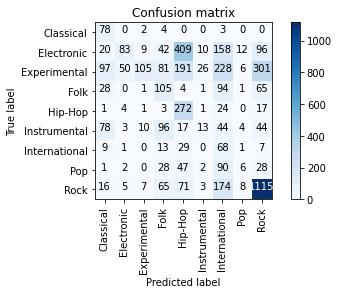

In [157]:
final_under_confusion_matrix = metrics.confusion_matrix(y_test, y_pred_final_undersample)
print(final_under_confusion_matrix)
plt.figure()
plot_confusion_matrix(final_under_confusion_matrix, labelNames)
plt.show()

In [158]:
ovr_knn_pca_ht_under = OneVsRestClassifier(knn_pca_ht)

undersampler = RandomUnderSampler(random_state = 0)
undersample_final_x_train, undersample_final_y_train = undersampler.fit_resample(reduced_train_features, y_train)

ovr_knn_pca_ht_under.fit(undersample_final_x_train, undersample_final_y_train)

y_pred_ovr_knn_probability_pca_ht_under = ovr_knn_pca_ht_under.predict_proba(reduced_test_features)

auc_score = roc_auc_score(y_test, y_pred_ovr_knn_probability_pca_ht_under, multi_class = 'ovr')
print(auc_score)

0.8338946038862752


# PCA , Over/Under sampling conclusion

PCA has improve the results in all 4 metrics while over/under sampling has lowered the performance of the model in all metrics

# ROC Curve

In [160]:
fpr = {}
tpr = {}
thresh ={}

n_class = 9

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred_ovr_knn_probability_pca_ht[:,i], pos_label=labelNames[i])

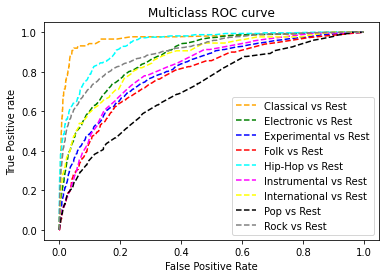

In [162]:
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Classical vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Electronic vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Experimental vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Folk vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='cyan', label='Hip-Hop vs Rest')
plt.plot(fpr[5], tpr[5], linestyle='--',color='magenta', label='Instrumental vs Rest')
plt.plot(fpr[6], tpr[6], linestyle='--',color='yellow', label='International vs Rest')
plt.plot(fpr[7], tpr[7], linestyle='--',color='black', label='Pop vs Rest')
plt.plot(fpr[8], tpr[8], linestyle='--',color='grey', label='Rock vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);

In [163]:
auc_score = roc_auc_score(y_test, y_pred_ovr_knn_probability_pca_ht, multi_class = 'ovr')
print(auc_score)

0.8524890392370323


In [107]:
print(metrics.classification_report(y_test, y_pred_final))

               precision    recall  f1-score   support

    Classical       0.48      0.69      0.57        87
   Electronic       0.69      0.49      0.57       839
 Experimental       0.56      0.43      0.49      1085
         Folk       0.23      0.18      0.20       299
      Hip-Hop       0.61      0.61      0.61       323
 Instrumental       0.50      0.01      0.02       309
International       0.83      0.04      0.07       128
          Pop       0.00      0.00      0.00       204
         Rock       0.51      0.92      0.66      1464

     accuracy                           0.54      4738
    macro avg       0.49      0.37      0.35      4738
 weighted avg       0.53      0.54      0.48      4738



C:\Users\hypw\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hypw\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hypw\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
